In [1]:
import numpy as np
import struct
import os
import glob
import xarray as xr
from datetime import datetime, timedelta
from mapper_functions import plot_global_tight_pcm, plot_NA_tight_pcm

In [2]:
expt_name = 'LS_DAv8_M36'

start_date = datetime(2002, 10, 1)
end_date = datetime(2006, 10, 1)

start_date_str = start_date.strftime('%Y/%m/%d')
end_date_str = end_date.strftime('%Y/%m/%d')

In [3]:
def read_ObsFcstAna(fname, isLDASsa=False):

    # Initialize outputs
    nodata = -9999

    date_time = {
        'year': nodata,
        'month': nodata,
        'day': nodata,
        'hour': nodata,
        'min': nodata,
        'sec': nodata,
        'dofyr': nodata,
        'pentad': nodata
    }

    obs_assim = []
    obs_species = []
    obs_tilenum = []
    obs_lon = []
    obs_lat = []
    obs_obs = []
    obs_obsvar = []
    obs_fcst = []
    obs_fcstvar = []
    obs_ana = []
    obs_anavar = []

    # Determine endianness
    machfmt = '>' if isLDASsa else '<'  # '>' for big-endian, '<' for little-endian

    if os.path.exists(fname):
        print(f"reading from {fname}")

        with open(fname, 'rb') as ifp:
            # Read N_obs and time stamp entry
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            N_obs = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            year, month, day, hour, minute, second, dofyr, pentad = struct.unpack(f'{machfmt}8i', ifp.read(32))
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            date_time = {
                'year': year,
                'month': month,
                'day': day,
                'hour': hour,
                'min': minute,
                'sec': second,
                'dofyr': dofyr,
                'pentad': pentad
            }

            # Read observation assim flag
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            tmp_data = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}i').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            obs_assim = np.zeros(N_obs, dtype=int)
            obs_assim[tmp_data != 0] = 1

            # Read species information
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_species = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}i').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # Read tile number information
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_tilenum = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}i').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # Read longitude
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_lon = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}f').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # Read latitude
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_lat = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}f').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # Read observation value
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_obs = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}f').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # Read observation variance
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_obsvar = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}f').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # Read observation-space model forecast value
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_fcst = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}f').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # Read observation-space model forecast variance
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_fcstvar = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}f').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # Read observation-space analysis value
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_ana = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}f').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # Read observation-space analysis variance
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            obs_anavar = np.frombuffer(ifp.read(N_obs * 4), dtype=f'{machfmt}f').copy()
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

            # No-data check
            obs_obsvar[obs_obsvar == nodata] = np.nan
            obs_fcst[obs_fcst == nodata] = np.nan
            obs_fcstvar[obs_fcstvar == nodata] = np.nan
            obs_ana[obs_ana == nodata] = np.nan
            obs_anavar[obs_anavar == nodata] = np.nan

    else:
        print(f"file does not exist: {fname}")

    return {'date_time': date_time, 
            'obs_assim': obs_assim, 
            'obs_species': obs_species, 
            'obs_tilenum': obs_tilenum, 
            'obs_lon': obs_lon, 
            'obs_lat': obs_lat,
            'obs_obs': obs_obs, 
            'obs_obsvar': obs_obsvar, 
            'obs_fcst': obs_fcst, 
            'obs_fcstvar': obs_fcstvar, 
            'obs_ana': obs_ana, 
            'obs_anavar': obs_anavar}

In [4]:
def read_tilecoord(fname):
    int_precision = 'i'
    float_precision = 'f'

    # Determine endianness
    machfmt = '<'  # '>' for big-endian, '<' for little-endian

    print(f"reading from {fname}")

    tile_coord = {}

    with open(fname, 'rb') as ifp:
        fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
        tile_coord['N_tile'] = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
        fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

        Nt = tile_coord['N_tile']

        fields = ['tile_id', 'typ', 'pfaf', 'com_lon', 'com_lat', 'min_lon', 'max_lon',
                      'min_lat', 'max_lat', 'i_indg', 'j_indg', 'frac_cell', 'frac_pfaf',
                      'area', 'elev']

        for field in fields:
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]
            dtype = int_precision if field in ['tile_id', 'typ', 'pfaf', 'i_indg', 'j_indg'] else float_precision
            tile_coord[field] = np.frombuffer(ifp.read(Nt * 4), dtype=f'{machfmt}{dtype}')
            fortran_tag = struct.unpack(f'{machfmt}i', ifp.read(4))[0]

In [5]:
def get_tile_species_max_values(ofa_data):
    """Get maximum observations per tile, split by species"""
    
    # Get unique values
    unique_tiles, tile_first_idx = np.unique(ofa_data['obs_tilenum'], return_index=True)
    unique_species = np.unique(ofa_data['obs_species'])
    
    # Get coordinates from first occurrences
    tile_lat = ofa_data['obs_lat'][tile_first_idx]
    tile_lon = ofa_data['obs_lon'][tile_first_idx]
    
    # Sort data for efficient processing
    sort_idx = np.argsort(ofa_data['obs_tilenum'])
    sorted_tiles = ofa_data['obs_tilenum'][sort_idx]
    sorted_species = ofa_data['obs_species'][sort_idx]
    sorted_obs = ofa_data['obs_obs'][sort_idx]
    
    # Initialize results dictionary
    results = {
        'tiles': unique_tiles,
        'lat': tile_lat,
        'lon': tile_lon,
        'max_values': {species: np.zeros(len(unique_tiles)) for species in unique_species}
    }
    
    # Find split points for tiles
    tile_splits = np.searchsorted(sorted_tiles, unique_tiles)
    tile_splits = np.append(tile_splits, len(sorted_tiles))
    
    # Calculate max obs_obs for each tile and species
    for i in range(len(unique_tiles)):
        tile_data = sorted_obs[tile_splits[i]:tile_splits[i+1]]
        tile_species = sorted_species[tile_splits[i]:tile_splits[i+1]]
        
        for species in unique_species:
            species_mask = tile_species == species
            if np.any(species_mask):
                results['max_values'][species][i] = np.max(tile_data[species_mask])
    
    return results


def get_tile_species_obs_values(ofa_data):
    """Get maximum observations per tile, the number of obs, and the number of obs > 0.9, split by species"""
    
    # Get unique values
    unique_tiles, tile_first_idx = np.unique(ofa_data['obs_tilenum'], return_index=True)
    unique_species = np.unique(ofa_data['obs_species'])
    
    # Get coordinates from first occurrences
    tile_lat = ofa_data['obs_lat'][tile_first_idx]
    tile_lon = ofa_data['obs_lon'][tile_first_idx]
    
    # Sort data for efficient processing
    sort_idx = np.argsort(ofa_data['obs_tilenum'])
    sorted_tiles = ofa_data['obs_tilenum'][sort_idx]
    sorted_species = ofa_data['obs_species'][sort_idx]
    sorted_obs = ofa_data['obs_obs'][sort_idx]
    
    # Initialize results dictionary
    results = {
        'tiles': unique_tiles,
        'lat': tile_lat,
        'lon': tile_lon,
        'max_values': {species: np.zeros(len(unique_tiles)) for species in unique_species},
        'num_obs': {species: np.zeros(len(unique_tiles)) for species in unique_species},
        'num_obs_gt_0.9': {species: np.zeros(len(unique_tiles)) for species in unique_species}
    }
    
    # Find split points for tiles
    tile_splits = np.searchsorted(sorted_tiles, unique_tiles)
    tile_splits = np.append(tile_splits, len(sorted_tiles))
    
    # Calculate max obs_obs for each tile and species
    for i in range(len(unique_tiles)):
        tile_data = sorted_obs[tile_splits[i]:tile_splits[i+1]]
        tile_species = sorted_species[tile_splits[i]:tile_splits[i+1]]
        
        for species in unique_species:
            species_mask = tile_species == species
            if np.any(species_mask):
                results['max_values'][species][i] = np.max(tile_data[species_mask])
                results['num_obs'][species][i] = np.sum(species_mask)
                results['num_obs_gt_0.9'][species][i] = np.sum(tile_data[species_mask] > 0.9)
    
    return results

In [6]:
OFA_list =[]

# ana_directory = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/snow_qc_expts/LS_DAv8_M36_snow_qc/LS_DAv8_M36_snow_qc/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/Y2005/M06'

ana_directory = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/Y2005/M04'

for fname in sorted([os.path.join(ana_directory, f) for f in os.listdir(ana_directory) if '.ldas_ObsFcstAna.' in f and f.endswith('.bin')]):
    if os.path.isfile(fname):
        OFA_list.append(read_ObsFcstAna(fname))

reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/Y2005/M04/LS_DAv8_M36.ens_avg.ldas_ObsFcstAna.20050401_0000z.bin
reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/Y2005/M04/LS_DAv8_M36.ens_avg.ldas_ObsFcstAna.20050401_0300z.bin
reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/Y2005/M04/LS_DAv8_M36.ens_avg.ldas_ObsFcstAna.20050401_0600z.bin
reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/Y2005/M04/LS_DAv8_M36.ens_avg.ldas_ObsFcstAna.20050401_0900z.bin
reading from /Users/amfox/Desktop/GEOSldas_diagnostics/test_data/land_sweeper/LS_DAv8_M36/output/SMAP_EASEv2_M36_GLOBAL/ana/ens_avg/Y2005/M04/LS_DAv8_M36.ens_avg.ldas_ObsFcstAna.20050401_1200z.bin
reading from /U

In [7]:
print(f"Length of OFA_list: {len(OFA_list)}")
print(f"\nShape of first element arrays:")
print(f"obs_assim: {OFA_list[0]['obs_assim'].shape}")
print(f"obs_species: {OFA_list[0]['obs_species'].shape}")
print(f"obs_tilenum: {OFA_list[0]['obs_tilenum'].shape}")

# Optional: check if all elements have same size
if len(OFA_list) > 1:
    print("\nComparing sizes across list:")
    for i in range(len(OFA_list)):
        print(f"Element {i}: {OFA_list[i]['obs_assim'].shape}")

Length of OFA_list: 240

Shape of first element arrays:
obs_assim: (7814,)
obs_species: (7814,)
obs_tilenum: (7814,)

Comparing sizes across list:
Element 0: (7814,)
Element 1: (21143,)
Element 2: (28624,)
Element 3: (35588,)
Element 4: (26964,)
Element 5: (16749,)
Element 6: (20712,)
Element 7: (10355,)
Element 8: (7024,)
Element 9: (21535,)
Element 10: (28878,)
Element 11: (36425,)
Element 12: (28550,)
Element 13: (17434,)
Element 14: (21517,)
Element 15: (10270,)
Element 16: (7495,)
Element 17: (21070,)
Element 18: (27386,)
Element 19: (34863,)
Element 20: (28829,)
Element 21: (17554,)
Element 22: (20215,)
Element 23: (9766,)
Element 24: (7897,)
Element 25: (20431,)
Element 26: (26832,)
Element 27: (34702,)
Element 28: (27059,)
Element 29: (18223,)
Element 30: (21757,)
Element 31: (10301,)
Element 32: (7670,)
Element 33: (20089,)
Element 34: (25283,)
Element 35: (34689,)
Element 36: (29106,)
Element 37: (17990,)
Element 38: (21693,)
Element 39: (10020,)
Element 40: (7442,)
Element 4

In [8]:
if OFA_list:
    print(OFA_list[0].keys())
else:
    print("OFA_list is empty.")


# Print first 5 values and array info
print("First 5 values:", OFA_list[0]['obs_assim'][:5])
print("Array shape:", OFA_list[0]['obs_assim'].shape)
print("Unique values:", np.unique(OFA_list[0]['obs_assim']))

dict_keys(['date_time', 'obs_assim', 'obs_species', 'obs_tilenum', 'obs_lon', 'obs_lat', 'obs_obs', 'obs_obsvar', 'obs_fcst', 'obs_fcstvar', 'obs_ana', 'obs_anavar'])
First 5 values: [1 1 1 1 1]
Array shape: (7814,)
Unique values: [1]


Number of unique tiles: 110823
Number of species: 2
Species 12: max value = 1.0
Species 13: max value = 1.0


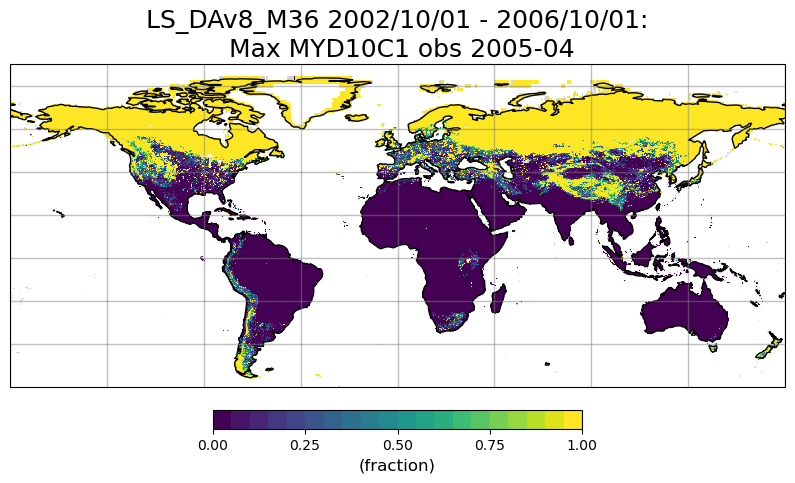

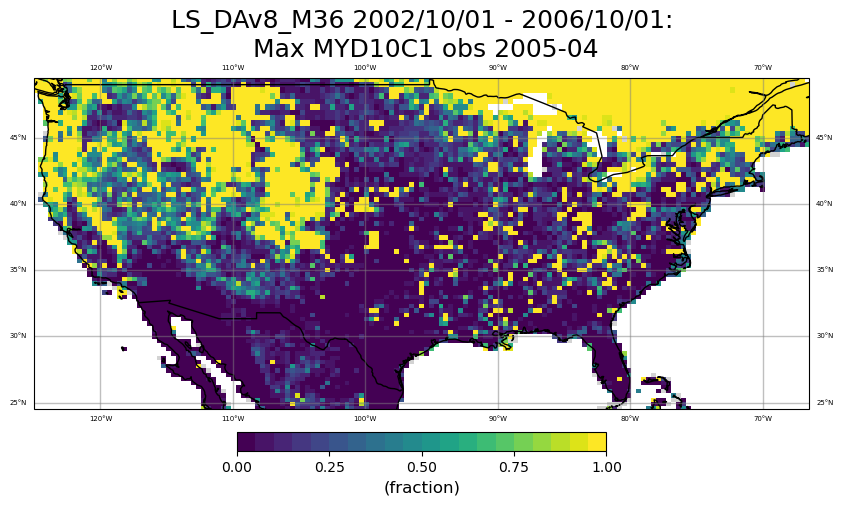

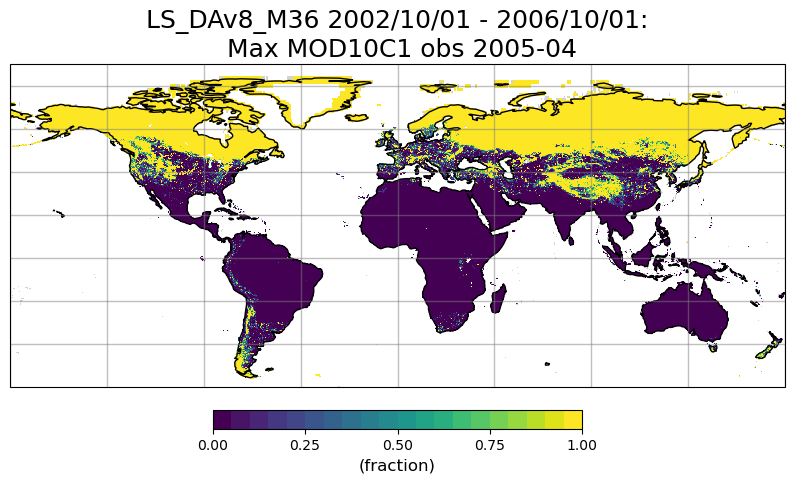

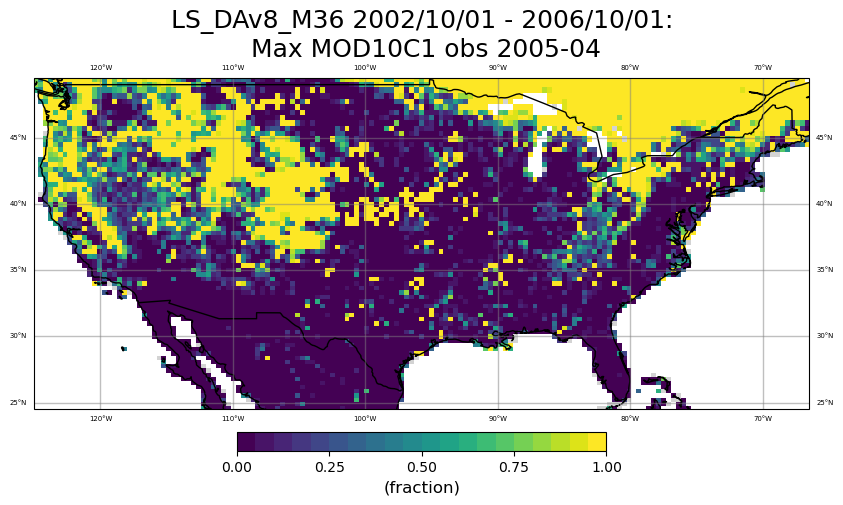

In [10]:
# Initialize lists to store filtered data
all_tilenums = []
all_species = []
all_lats = []
all_lons = []
all_obs = []

# Process each element in OFA_list
for ofa in OFA_list:
    # Create mask for this element
    assim_mask = ofa['obs_assim'] == 1
    
    # Append filtered data
    all_tilenums.append(ofa['obs_tilenum'][assim_mask])
    all_species.append(ofa['obs_species'][assim_mask])
    all_lats.append(ofa['obs_lat'][assim_mask])
    all_lons.append(ofa['obs_lon'][assim_mask])
    all_obs.append(ofa['obs_obs'][assim_mask])

# Create filtered dictionary with concatenated data
filtered_data = {
    'obs_tilenum': np.concatenate(all_tilenums),
    'obs_species': np.concatenate(all_species),
    'obs_lat': np.concatenate(all_lats),
    'obs_lon': np.concatenate(all_lons),
    'obs_obs': np.concatenate(all_obs)
}

# Process filtered data
stats = get_tile_species_max_values(filtered_data)

# Print summary
print(f"Number of unique tiles: {len(stats['tiles'])}")
print(f"Number of species: {len(stats['max_values'])}")
for species, max_vals in stats['max_values'].items():
    print(f"Species {species}: max value = {np.max(max_vals)}")

# Initialize map_array with NaN values
map_array = np.empty((stats['lon'].shape[0], 3))  # Shape: (number of tiles, 3)
map_array.fill(np.nan)

# Fill longitude and latitude columns
map_array[:, 1] = stats['lon']  # Assuming `lon` contains longitude values
map_array[:, 2] = stats['lat']  # Assuming `lat` contains latitude values

map_array[:, 0] = stats['max_values'][12]

plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max MYD10C1 obs 2005-04', 'fraction', 0, 1)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max MYD10C1 obs 2005-04', 'fraction', 0, 1)

map_array[:, 0] = stats['max_values'][13]

plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max MOD10C1 obs 2005-04', 'fraction', 0, 1)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max MOD10C1 obs 2005-04', 'fraction', 0, 1)


First date: 2005-07-01 03:00:00
Last date: 2005-07-31 21:00:00
Total timesteps: 247
FrozenMappingWarningOnValuesAccess({'time': 247, 'tile': 112573})
Data variables:
    lon                 (time, tile) float32 111MB dask.array<chunksize=(1, 112573), meta=np.ndarray>
    lat                 (time, tile) float32 111MB dask.array<chunksize=(1, 112573), meta=np.ndarray>
    IG                  (time, tile) int32 111MB dask.array<chunksize=(1, 112573), meta=np.ndarray>
    JG                  (time, tile) int32 111MB dask.array<chunksize=(1, 112573), meta=np.ndarray>
    SFMC_FCST           (time, tile) float32 111MB dask.array<chunksize=(1, 112573), meta=np.ndarray>
    RZMC_FCST           (time, tile) float32 111MB dask.array<chunksize=(1, 112573), meta=np.ndarray>
    PRMC_FCST           (time, tile) float32 111MB dask.array<chunksize=(1, 112573), meta=np.ndarray>
    TSURF_FCST          (time, tile) float32 111MB dask.array<chunksize=(1, 112573), meta=np.ndarray>
    TSOIL1_FCST       

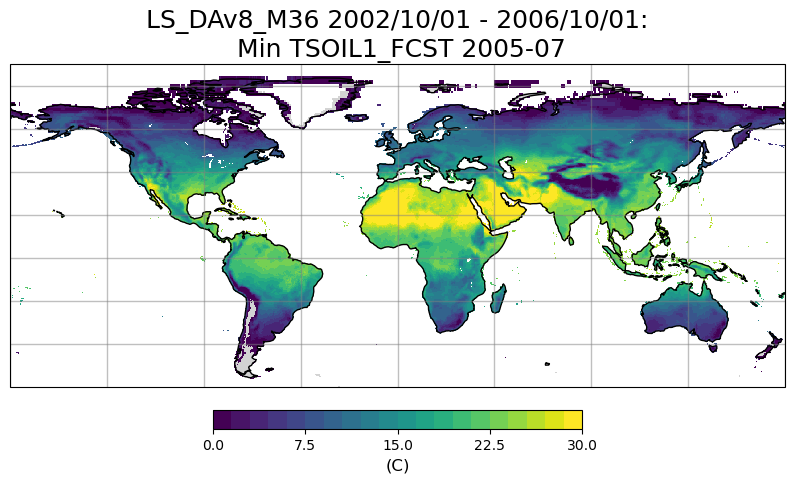

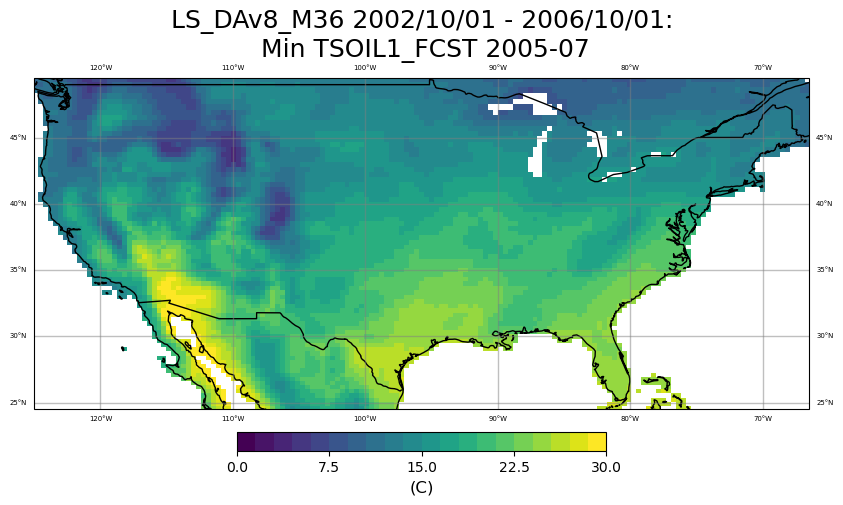

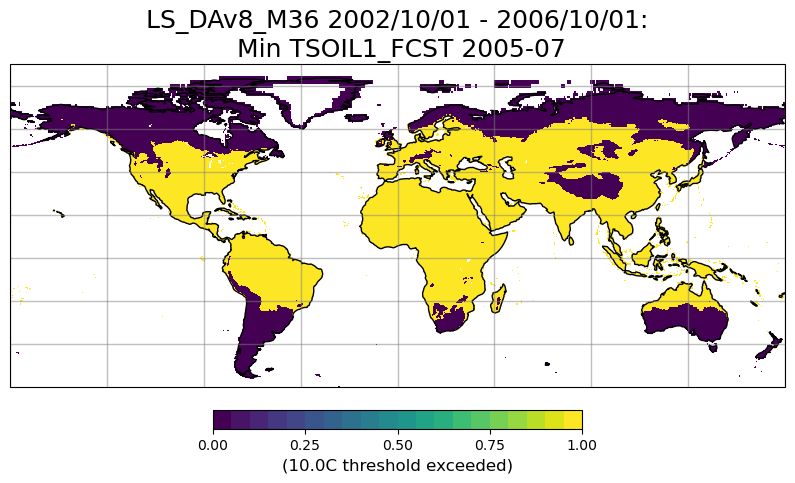

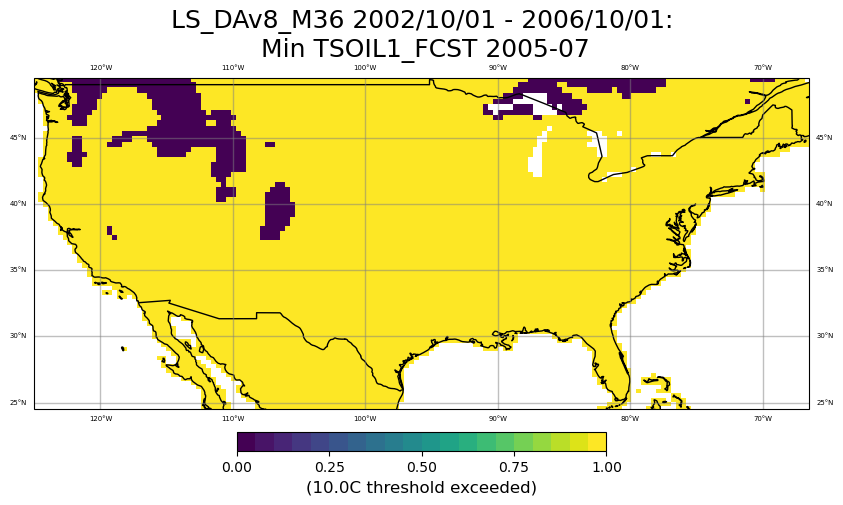

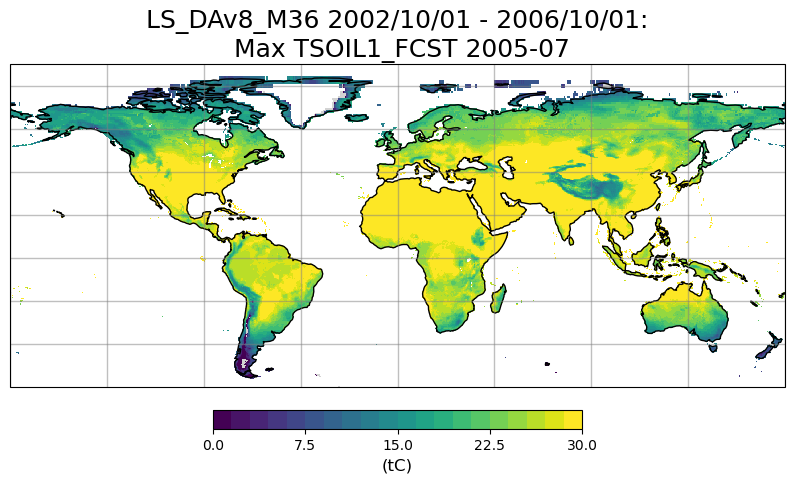

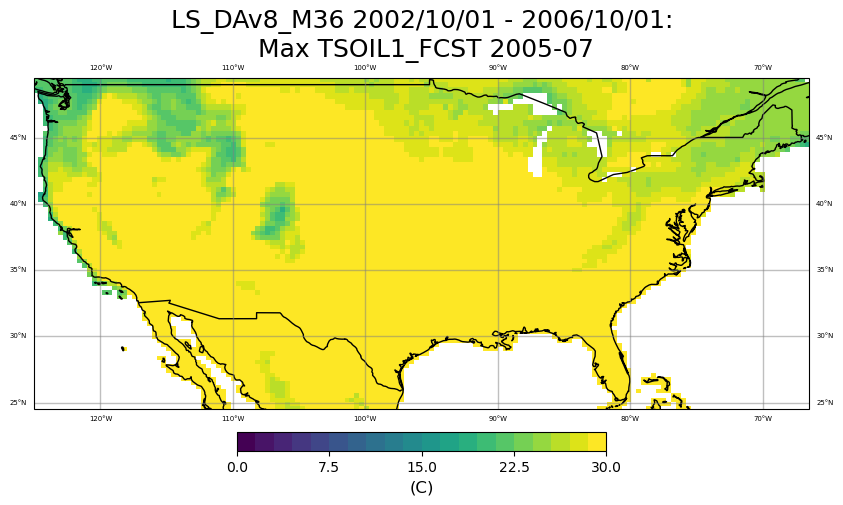

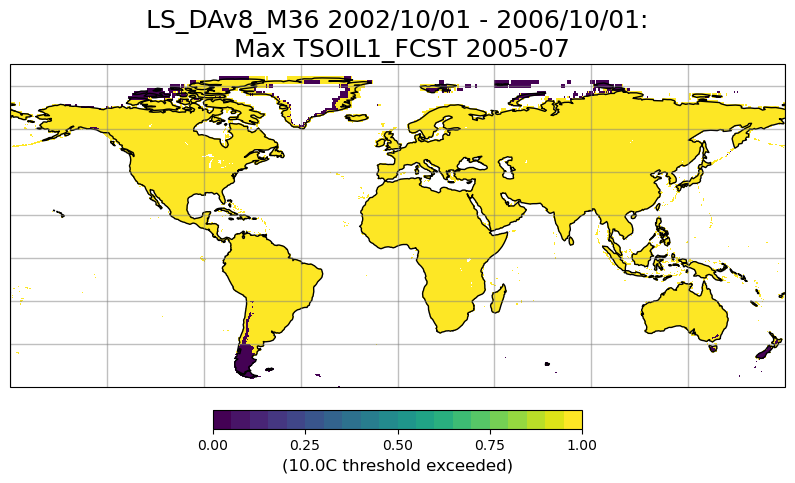

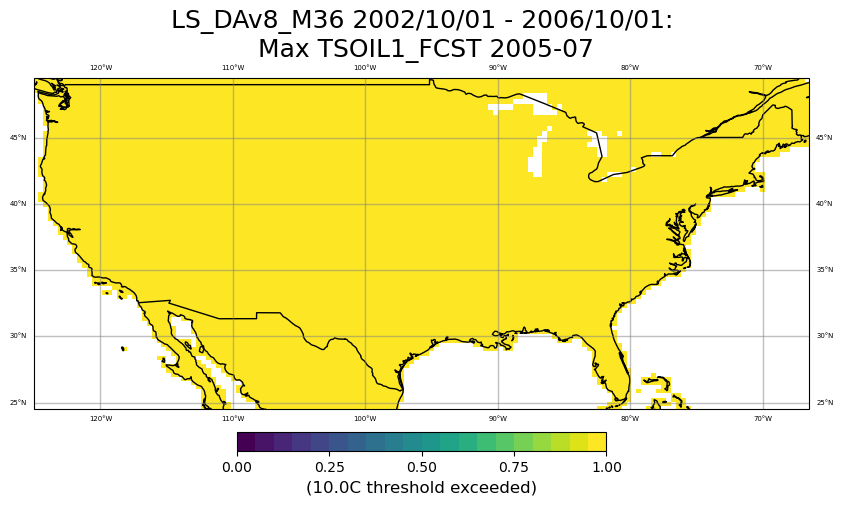

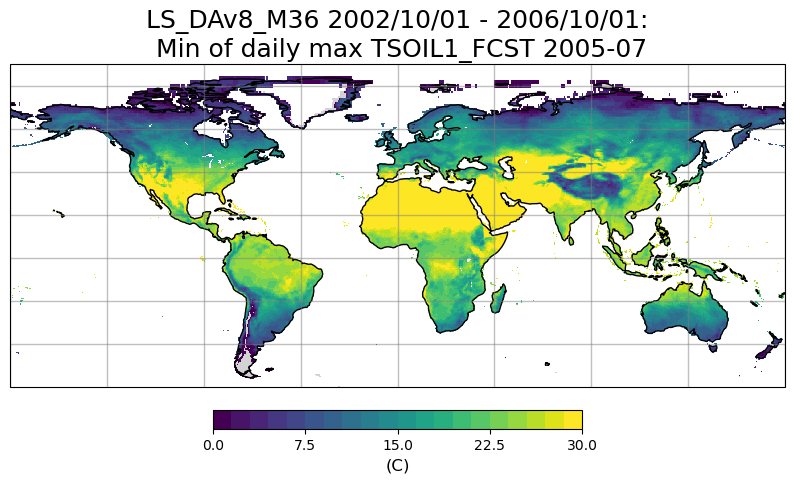

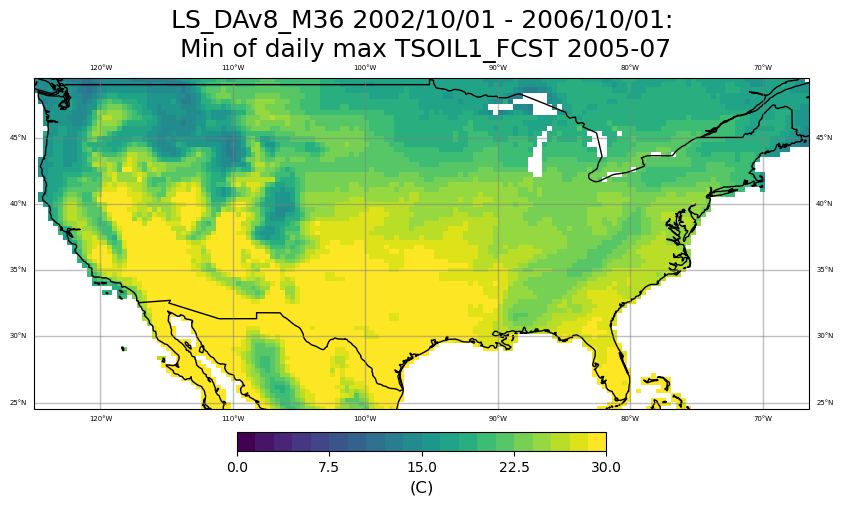

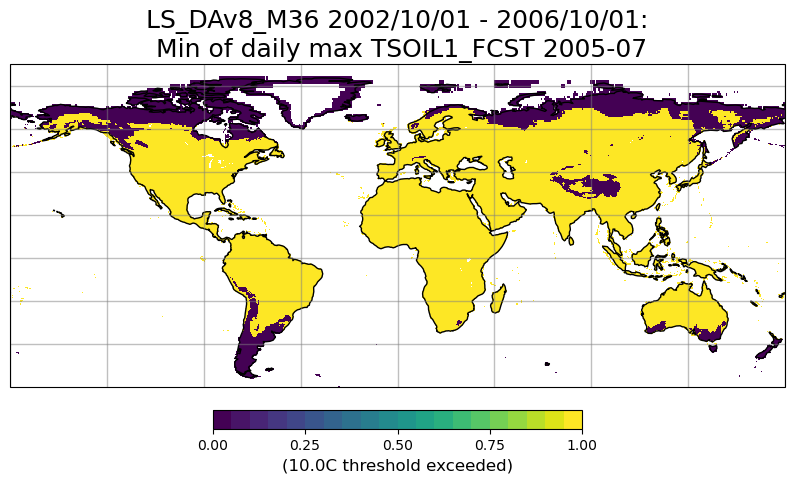

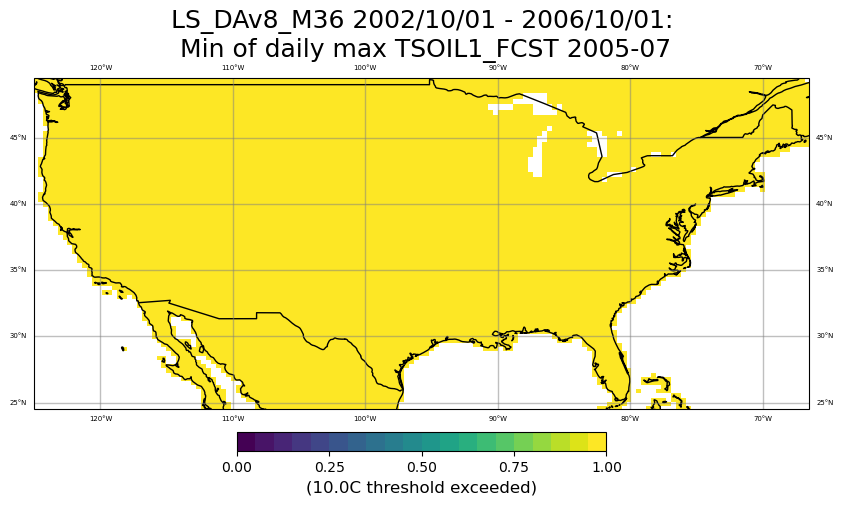

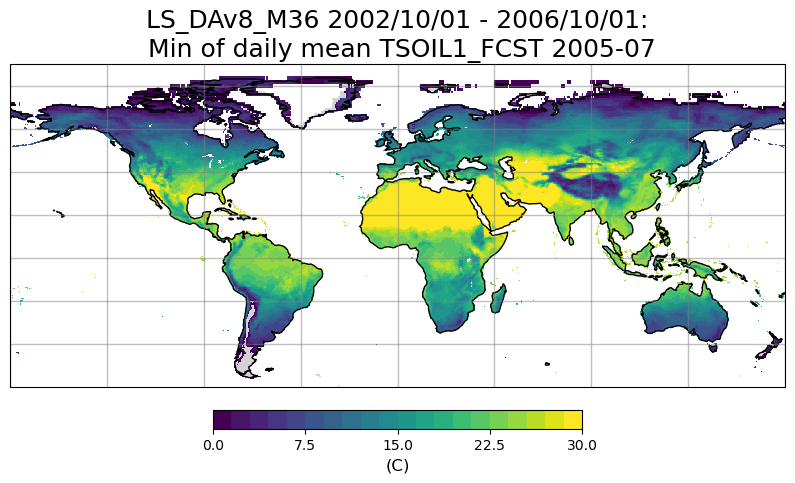

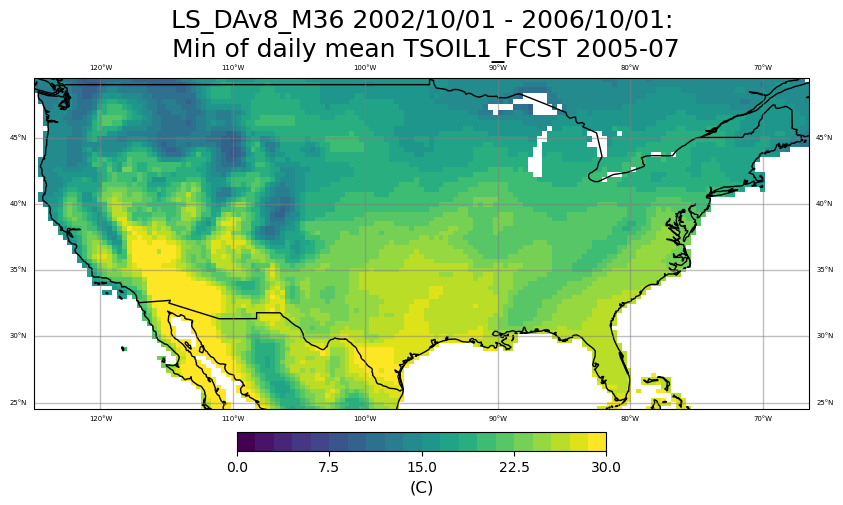

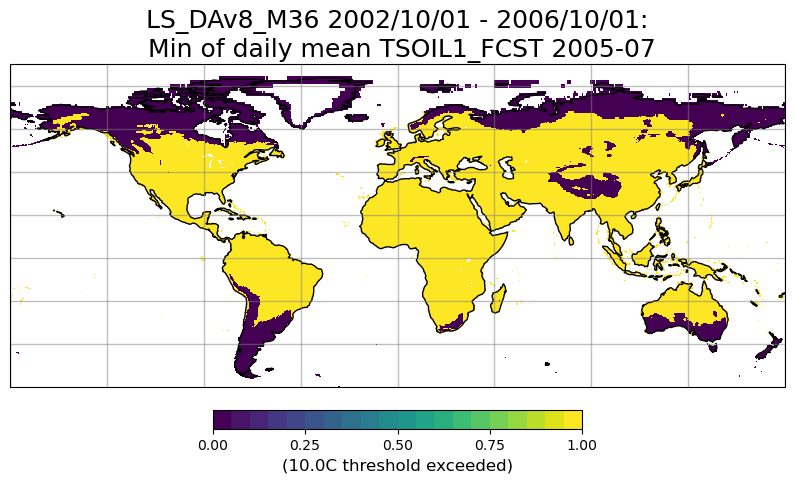

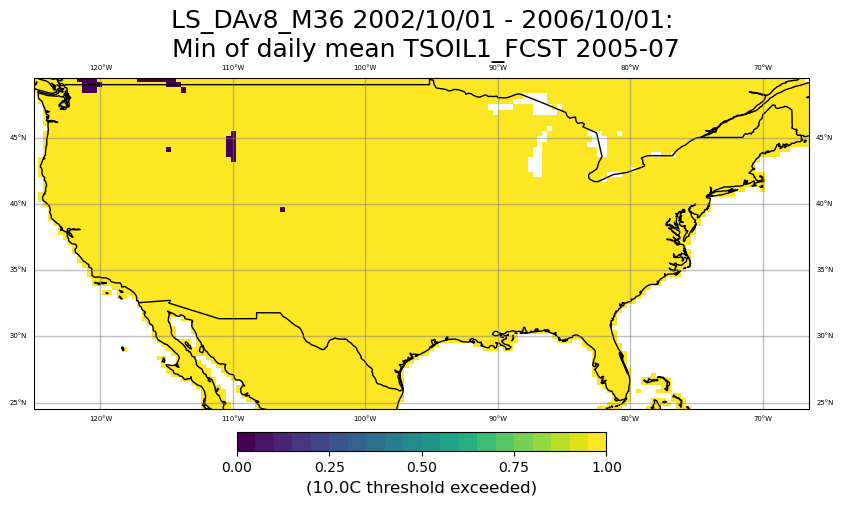

In [15]:
root_directory = '/Users/amfox/Desktop/GEOSldas_diagnostics/test_data/snow_qc_expts/LS_DAv8_M36_snow_qc/test_LS_DAv8_M36_snow_qc/output/SMAP_EASEv2_M36_GLOBAL/cat/ens_avg/Y2005/M07/'

files = glob.glob(os.path.join(root_directory, 'test_LS_DAv8_M36_snow_qc.inst3_1d_lndfcstana_Nt.*.nc4'))

# Load the data 
ds_lndfcstana = xr.open_mfdataset(files, combine='nested', concat_dim="time")

# Sort the dataset by the time dimension
ds_lndfcstana = ds_lndfcstana.sortby('time')

# Extract the time variable
time_var = ds_lndfcstana['time']
# Convert the time variable to a numpy array
time_values = time_var.values

def create_date_array(time_values, start_date):
    """Convert array of 3-hour increments to datetime objects"""
    # Convert numpy integers to Python integers
    time_ints = [int(t) for t in time_values]
    
    # Create datetime array
    dates = [start_date + timedelta(hours=3*t) for t in time_ints]
    return np.array(dates)

# Create date array
start_date = datetime(2005, 7, 1, 3)
dates = create_date_array(time_values, start_date)

# Verify conversion
print(f"First date: {dates[0]}")
print(f"Last date: {dates[-1]}")
print(f"Total timesteps: {len(dates)}")

# Print the shape of the dataset
print(ds_lndfcstana.dims)
# Print the names of the variables in the dataset
print(ds_lndfcstana.data_vars)

TSOIL1_FCST = ds_lndfcstana['TSOIL1_FCST']

# Calculate min and max per tile
tile_min = TSOIL1_FCST.min(dim='time') - 273.15
tile_max = TSOIL1_FCST.max(dim='time') - 273.15

# Convert to numpy arrays (compute dask arrays)
min_vals = tile_min.compute()
max_vals = tile_max.compute()

temperature_threshold = 10.0

t_thres_str = f'{temperature_threshold:.1f}C'

min_vals_thres = xr.where(min_vals > temperature_threshold, 1, 0)
max_vals_thres = xr.where(max_vals > temperature_threshold, 1, 0)
# Convert to numpy arrays
min_vals_thres = min_vals_thres.values
max_vals_thres = max_vals_thres.values

# Print some statistics
print(f"Global min: {min_vals.min():.2f}K")
print(f"Global max: {max_vals.max():.2f}K")
print(f"Number of tiles: {len(min_vals)}")

# Convert xarray time coordinates to datetime
TSOIL1_FCST = TSOIL1_FCST.assign_coords(time=dates)

# Resample to daily frequency and get maximum
daily_max = TSOIL1_FCST.resample(time='D').max()

# Get minimum of daily maximums for each tile
min_of_daily_max = daily_max.min(dim='time') - 273.15

min_of_daily_max_thres = xr.where(min_of_daily_max > temperature_threshold, 1, 0)

# Resample to daily frequency and get mean
daily_mean = TSOIL1_FCST.resample(time='D').mean()
# Get minimum of daily means for each tile
min_of_daily_mean = daily_mean.min(dim='time') - 273.15
min_of_daily_mean_thres = xr.where(min_of_daily_mean > temperature_threshold, 1, 0)

print(f"Shape of min_of_daily_max: {min_of_daily_max.shape}")
print(f"Global min of daily max: {min_of_daily_max.min().values:.2f}°C")
print(f"Global max of daily max: {min_of_daily_max.max().values:.2f}°C")


# Get lons from first time slice
lons = ds_lndfcstana['lon'].isel(time=0).values
lats = ds_lndfcstana['lat'].isel(time=0).values

# Create map_array for plotting
map_array = np.empty((len(lons), 3))  # Shape: (number of tiles, 3)
map_array.fill(np.nan)
# Fill longitude and latitude columns
map_array[:, 1] = lons  # Assuming `lon` contains longitude values
map_array[:, 2] = lats  # Assuming `lat` contains latitude values
# Fill temperature values
map_array[:, 0] = min_vals
# Plotting
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min TSOIL1_FCST 2005-07', 'C', 0, 30)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min TSOIL1_FCST 2005-07', 'C', 0, 30)

map_array[:, 0] = min_vals_thres
# Plotting
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min TSOIL1_FCST 2005-07', f'{t_thres_str} threshold exceeded', 0, 1)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min TSOIL1_FCST 2005-07', f'{t_thres_str} threshold exceeded', 0, 1)

# Fill temperature values
map_array[:, 0] = max_vals
# Plotting
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max TSOIL1_FCST 2005-07', 'tC', 0, 30)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max TSOIL1_FCST 2005-07', 'C', 0, 30)

map_array[:, 0] = max_vals_thres
# Plotting
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max TSOIL1_FCST 2005-07', f'{t_thres_str} threshold exceeded', 0, 1)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Max TSOIL1_FCST 2005-07', f'{t_thres_str} threshold exceeded', 0, 1)

map_array[:, 0] = min_of_daily_max
# Plotting
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min of daily max TSOIL1_FCST 2005-07', 'C', 0, 30)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min of daily max TSOIL1_FCST 2005-07', 'C', 0, 30)

map_array[:, 0] = min_of_daily_max_thres
# Plotting
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min of daily max TSOIL1_FCST 2005-07', f'{t_thres_str} threshold exceeded', 0, 1)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min of daily max TSOIL1_FCST 2005-07', f'{t_thres_str} threshold exceeded', 0, 1)

map_array[:, 0] = min_of_daily_mean

# Plotting
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min of daily mean TSOIL1_FCST 2005-07', 'C', 0, 30)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min of daily mean TSOIL1_FCST 2005-07', 'C', 0, 30)

map_array[:, 0] = min_of_daily_mean_thres

# Plotting
plot_global_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min of daily mean TSOIL1_FCST 2005-07', f'{t_thres_str} threshold exceeded', 0, 1)
plot_NA_tight_pcm(map_array, False, False, f'{expt_name} {start_date_str} - {end_date_str}:\n Min of daily mean TSOIL1_FCST 2005-07', f'{t_thres_str} threshold exceeded', 0, 1)

# Close the dataset
ds_lndfcstana.close()
